In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import math
import os
import random
from functools import partial
from decimal import Decimal
import numpy as np
# from sklearnex import patch_sklearn; patch_sklearn()
import scipy.io as sio
import pysindy as ps
from tqdm import trange

# NSGA2, DNSGA2, SMSEMOA, AGEMOEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

from utils import *
from skimage.restoration import estimate_sigma
import bm3d
# from okridge.solvel0 import *
from solvel0 import solvel0, MIOSR
from best_subset import backward_refinement, brute_force_all_subsets
from UBIC import *
from kneed import KneeLocator
from bayesian_model_evidence import log_evidence

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

sage is not installed to the environment.
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
L0BnB is not installed.


In [2]:
n_poly = 6
n_derivatives = 6
n_modules = 8

In [3]:
data_path = "../PDE-Discovery-EC/Datasets/"
print(os.listdir(data_path))
data = sio.loadmat(os.path.join(data_path, "kuramoto_sivishinky.mat"))
u_clean = (data['uu']).real; u = u_clean.copy()
x = data['x'].ravel()
t = data['tt'].ravel()
dt = t[1]-t[0]; dx = x[2]-x[1]

['KdV_sine_rep_big.mat', 'kuramoto_sivishinky.mat', 'lorenz100.npy', 'Wave_equation', 'KdV_rudy.mat', 'lorenz10.npy', 'KG_Exp.mat', 'burgers.mat']


### Add noise

In [4]:
np.random.seed(0)
noise_type = "gaussian"
noise_lv = float(50)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

Noise level: 50.0


### Gaussian process
    - removing entries in x that show high std

In [5]:
import gpax

load_denoised_data = True
if load_denoised_data:
    print("Loading denoised data...")
    u = np.load(f"./Denoised_data/ks_{noise_type}{int(noise_lv)}_bm3d.npy")
else:
    print("Denoising")
    n_sampled_t = 10
    xx = colvec(x)
    u_std = np.ones((u.shape[0], n_sampled_t))
    for i in range(n_sampled_t):
        rng_key_train, rng_key_predict = gpax.utils.get_keys()
    
        gp_model = gpax.ExactGP(1, kernel='RBF')
        gp_model.fit(rng_key_train, xx, u[:, np.random.choice(len(t))], 
                     num_warmup=5, num_samples=20, jitter=1e-6, 
                     chain_method='parallel', print_summary=False)
    
        posterior_mean, f_samples = gp_model.predict(rng_key_predict, xx)
        u_std[:, i] = np.std(f_samples[:, 0, :], axis=0)
    
    print(u_std.mean(), u_std.max())
    est_sigma = u_std.mean() # max also works well

    u = bm3d.bm3d(u, sigma_psd=est_sigma, 
                  stage_arg=bm3d.BM3DStages.ALL_STAGES, 
                  blockmatches=(False, False))

    np.save(f"./Denoised_data/ks_{noise_type}{int(noise_lv)}_bm3d.npy", u)

Loading denoised data...


In [6]:
# n_sampled_t = 10

# kernel = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) + \
#         WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))

# xx = colvec(x)
# u_std = np.ones((u.shape[0], n_sampled_t))
# for i in trange(n_sampled_t):    
#     gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, 
#                                    n_restarts_optimizer=10 # 20
#                                   )

#     gpr.fit(xx, u[:, np.random.choice(len(t))])
#     _, ustd = gpr.predict(xx, return_std=True)
#     u_std[:, i] = ustd
    
# est_sigma = u_std.mean() # max also works well
# cutoff_ws = knee(range(21), 
#                  [u_std.std()]+[u_std[ws:-ws, :].std() for ws in range(1, 21)], 
#                  'linear')
# if cutoff_ws > 0:
#     u = u[cutoff_ws:-cutoff_ws, :]
#     x = x[cutoff_ws:-cutoff_ws]
    
# est_sigma, cutoff_ws

### Denoise

In [7]:
xt = np.array([x.reshape(-1, 1), t.reshape(1, -1)], dtype=object)
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [8]:
function_library = ps.PolynomialLibrary(degree=n_poly, include_bias=False)

weak_lib = ps.WeakPDELibrary(
    function_library=function_library,
    derivative_order=n_derivatives,
    spatiotemporal_grid=XT,
    include_bias=True,
    K=10000
)

X_pre = np.array(weak_lib.fit_transform(np.expand_dims(u, -1)))
y_pre = weak_lib.convert_u_dot_integral(np.expand_dims(u, -1))
feature_names = np.array(weak_lib.get_feature_names(), dtype=object)
R_path = "./Cache/"
np.save(os.path.join(R_path, f"X_pre_ks_noise{int(noise_lv)}.npy"), X_pre)
np.save(os.path.join(R_path, f"y_pre_ks_noise{int(noise_lv)}.npy"), y_pre)
np.save(os.path.join(R_path, f"feature_names_ks.npy"), feature_names)

In [9]:
base_poly = np.array([[p, 0] for p in range(1, n_poly+1)])
base_derivative = np.array([[0, d] for d in range(1, n_derivatives+1)])
modules = [(0, 0)] if weak_lib.include_bias else []
modules += [(p, 0) for p in range(1, n_poly+1)] + \
            [(0, d) for d in range(1, n_derivatives+1)] + \
            [tuple(p+d) for d in base_derivative for p in base_poly]
assert len(modules) == len(weak_lib.get_feature_names())
base_features = dict(zip(modules, X_pre.T))
u_t = y_pre.copy()

In [10]:
# miosr_subsets = solvel0(X_pre, y_pre, miosr=True)

### Genetic algorithm with NSGA-II

In [11]:
class PdeDiscoveryProblem(ElementwiseProblem):
    def __init__(self, n_poly, n_derivatives, n_modules, 
                 base_features, u_t, order_complexity=False):
        super().__init__(n_var=1, n_obj=2, n_ieq_constr=0)
        self.n_poly = n_poly
        self.n_derivatives = n_derivatives
        self.n_modules = n_modules
        self.base_features = base_features
        self.u_t = u_t
        self.sample_size = np.prod(self.u_t.shape)
        self.order_complexity = order_complexity

    def _evaluate(self, X, out, *args, **kwargs):
        genome = X[0]
        coeff, mse = self.compute_genome_coefficient(genome)
        mse = mse/self.sample_size
        complexity_penalty = len(genome)
        if self.order_complexity:
            complexity_penalty += sum(sum(_) for _ in genome)
        out["F"] = [mse, complexity_penalty]
        
    def numericalize_genome(self, genome):
        return np.stack([self.base_features[tuple(module)] 
                         for module in genome], axis=-1)

    def compute_genome_coefficient(self, genome):
        features = self.numericalize_genome(genome)
        features = features.reshape(-1, features.shape[-1])
        coeff, error, _, _ = np.linalg.lstsq(features, self.u_t, rcond=None)
        return coeff, error[0]
    
    def generate_module(self):
        return (random.randint(0, self.n_poly), random.randint(0, self.n_derivatives))
    
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
    
class PopulationSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, 1), None, dtype=object)
        X_set = set()
        i = 0
        while i < n_samples:
            n_modules = random.randint(1, problem.n_modules)
            genome = frozenset(problem.generate_module() for _ in range(n_modules))
            if len(genome) > 0 and genome not in X_set:
                X_set.add(genome)
                X[i, 0] = genome
                i += 1
        return X
    
class DuplicateElimination(ElementwiseDuplicateElimination):
    def is_equal(self, g1, g2):
        return g1.X[0] == g2.X[0]

In [12]:
class GenomeCrossover(Crossover):
    def __init__(self):
        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):
        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape

        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)
        
        # for each mating provided
        for k in range(n_matings):
            # get the first and the second parent          
            Y[0, k, 0], Y[1, k, 0] = self.crossover_permutation(X[0, k, 0], X[1, k, 0])
            
        return Y
    
    def crossover_permutation(self, genome1, genome2):
        collection = list(genome1) + list(genome2)
        random.shuffle(collection)
        return frozenset(collection[:len(genome1)]), frozenset(collection[len(genome1):])
    
class GenomeMutation(Mutation):
    def __init__(self, add_rate=0.4, del_rate=0.5, order_rate=0.4):
        super().__init__()
        self.add_rate = add_rate
        self.del_rate = del_rate
        self.order_rate = order_rate

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            if random.random() < self.add_rate:
                X[i, 0] = self.add_mutate(problem, X[i, 0])
            if random.random() < self.del_rate:
                X[i, 0] = self.del_mutate(problem, X[i, 0])
            if random.random() < self.order_rate:
                X[i, 0] = self.module_mutate(problem, X[i, 0])
        return X
    
    def add_mutate(self, problem, genome, max_iter=3):
        for _ in range(max_iter):
            new_module = problem.generate_module()
            if new_module not in genome:
                return genome.union(frozenset({new_module}))
        return genome
    
    def del_mutate(self, problem, genome, max_iter=3):
        genome = list(genome)
        lg = len(genome)
        if lg > 0:
            if lg == 1:
                for _ in range(max_iter):
                    new_module = problem.generate_module()
                    if new_module != genome[0]:
                        return frozenset({new_module})
            else:
                genome.pop(random.randint(0, lg-1))
        return frozenset(genome)
    
    def module_mutate(self, problem, genome):
        if len(genome) == 0:
            return genome
        genome = set(genome)
        genome.remove(random.choice(list(genome)))
        for _ in range(3):
            new_module = problem.generate_module()
            if new_module not in genome:
                genome.add(new_module)
                return frozenset(genome)
        return frozenset(genome)

In [13]:
pop_size = 500
problem = PdeDiscoveryProblem(n_poly, n_derivatives, n_modules, 
                              base_features, u_t, order_complexity=False)

In [14]:
load_pareto_front = True

if not load_pareto_front:
    termination = DefaultMultiObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-8,
        period=50,
        n_max_gen=100,
        n_max_evals=100000
    )

    algorithm = DNSGA2( 
                    pop_size=pop_size,
                    sampling=PopulationSampling(),
                    crossover=GenomeCrossover(),
                    mutation=GenomeMutation(),
                    eliminate_duplicates=DuplicateElimination())

    res = minimize(problem,
                algorithm,
                termination=termination,
                verbose=True)
    
    pareto_optimal_models = res.X
    np.save(f"./Cache/pf_ks_noise{int(noise_lv)}.npy", pareto_optimal_models)

else:
    pareto_optimal_models = np.load(f"./Cache/pf_ks_noise{int(noise_lv)}.npy", allow_pickle=True)


In [15]:
### OPTIONAL ###
from operator import itemgetter

effective_candidates = frozenset()
for i in range(len(pareto_optimal_models)):
    effective_candidates = effective_candidates.union(pareto_optimal_models[i][0])
effective_candidates = sorted(effective_candidates)

new_pareto_optimal_models = []
for bs in backward_refinement([sorted([effective_candidates.index(_) for _ in list(pm[0])]) for pm in pareto_optimal_models], 
                              (problem.numericalize_genome(effective_candidates), y_pre)).get_best_subsets():
    bs = itemgetter(*bs)(effective_candidates)
    if type(bs[0]) is not tuple:
        bs = (bs,)
    new_pareto_optimal_models.append([frozenset(bs)])
pareto_optimal_models = np.array(new_pareto_optimal_models)
del new_pareto_optimal_models
# pareto_optimal_models

In [16]:
from collections import Counter
from pymcdm.methods import TOPSIS, MABAC, COMET, SPOTIS
from pymcdm import weights as obj_w
from pymcdm.helpers import rrankdata
from pymcdm.methods.comet_tools import MethodExpert
from pymcdm import visuals

F = problem.evaluate(pareto_optimal_models)
nF = (F - F.min(axis=0))/(F.max(axis=0) - F.min(axis=0))

obj_weights = obj_w.entropy_weights(F)
types = [-1, -1]
cvalues = COMET.make_cvalues(F)
expert_function = MethodExpert(TOPSIS(), obj_weights, types)
bounds = SPOTIS.make_bounds(F)

method_names = ['TOPSIS', 'MABAC', 'COMET', 'SPOTIS']
methods = [
    TOPSIS(),
    MABAC(),
    COMET(cvalues, expert_function),
    SPOTIS(bounds)
]

ranks = [method.rank(method(F, obj_weights, types)) for method in methods]
balance_point = F[sorted(Counter(np.argmin(ranks, axis=1)).most_common())[0][0]]
print("Optimal balance:", balance_point)
est_complexities = sorted(set(np.argsort(ranks)[:, 0]))
pareto_optimal_models = pareto_optimal_models[est_complexities]
est_complexities = F[est_complexities][:, 1].astype(np.int32)

min_ss = min(est_complexities)
max_ss = max(est_complexities)
if max_ss == min_ss:
    max_ss += 1

# fig, ax = plt.subplots(figsize=(7, 3), dpi=300, tight_layout=True)
# visuals.ranking_bar(ranks, labels=method_names, ax=ax)
# plt.show()
pareto_optimal_models

Optimal balance: [0.03194801 3.        ]


array([[frozenset({(1, 1), (0, 2), (0, 4)})]], dtype=object)

In [17]:
significance_threshold = None

effective_candidates = frozenset()
for i in range(len(pareto_optimal_models)):
    effective_candidates = effective_candidates.union(pareto_optimal_models[i][0])
    
effective_candidates = {_: 0.0 for _ in effective_candidates}
for i in range(len(pareto_optimal_models)):
    potential_pde = list(pareto_optimal_models[i][0])
    important_scores = shap_linear_importance(problem.numericalize_genome(potential_pde), 
                                              y_pre, scale=True)
    for j in range(len(potential_pde)):
        effective_candidates[potential_pde[j]] += important_scores[j]
        
total_score = sum(effective_candidates.values())
for _ in effective_candidates:
    effective_candidates[_] = effective_candidates[_]/total_score

effective_candidates = sorted(effective_candidates.items(), key=lambda _: _[1], reverse=True)
cum_sum = 0
cum_sums = []
top_candidates = []
for i in range(len(effective_candidates)):
    cum_sum += effective_candidates[i][1]
    cum_sums.append(cum_sum)
    top_candidates.append(effective_candidates[i][0])
if significance_threshold is not None:
    top_candidates = top_candidates[:np.argmax((np.array(cum_sums) > significance_threshold).astype(np.int8))+1]
else:
    top_candidates = top_candidates[:knee(range(0, len(cum_sums)), cum_sums, S=1, direction='increasing')+1]

if len(top_candidates) > max_ss:
    top_candidates = np.array(top_candidates)[np.nonzero(linear_model.ARDRegression(max_iter=500, fit_intercept=False).fit(problem.numericalize_genome(top_candidates), y_pre.ravel()).coef_)[0]]
else:
    top_candidates = np.array(top_candidates)
X_pre_top = problem.numericalize_genome(top_candidates)

top_candidates

array([[0, 2],
       [0, 4],
       [1, 1]])

### Using KnockoffFilter to compute X_pre_top instead of GA

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from abess import LinearRegression as AbessLinearRegression
# from L0learn import L0Learn
# from SCO import SCO
from knockpy import KnockoffFilter, knockoff_stats, knockoffs
from knockpy.utilities import estimate_covariance
from scipy import stats
from statsmodels.stats.multitest import multipletests
from c2st.check import c2st # https://github.com/psteinb/c2st

u_pre = y_pre.copy()
X_pre_top = StandardScaler().fit_transform(X_pre)
y_pre = StandardScaler().fit_transform(u_pre)

# lr = SCO(path_type='gs', sparsity=10, ic_method='LinearSIC')
lr = AbessLinearRegression(path_type='gs', s_max=10, fit_intercept=False, cv=5, screening_size=0)

### GOODS: ShapStatistic, PIStatistic, Eli5PIStatistic, AlibiPDStatistic ###
# fstat = knockoff_stats.FeatureStatistic(model=lr)
fstat = knockoff_stats.ShapStatistic(model=lr)
# fstat = knockoff_stats.PIStatistic(model=lr)
# fstat = knockoff_stats.PIMPStatistic(model=lr, feature_names=feature_names)
# fstat = knockoff_stats.AlibiPIStatistic(model=lr, n_repeats=30) # slow
# fstat = knockoff_stats.AlibiPDStatistic(model=lr)
# fstat = knockoff_stats.Eli5PIStatistic(model=lr, n_iter=10)

kfilter = KnockoffFilter(ksampler='gaussian', fstat=fstat, 
                         knockoff_kwargs={'method':'ci'}, 
                         # fstat_kwargs={'feature_importance': 'swapint'} # swap, swapint
                        )
# kfilter = KnockoffFilter(ksampler='gaussian', fstat='lasso', knockoff_kwargs={'method':'ci'})

rejections = []
for _ in trange(50):
    rejection = kfilter.forward(X=X_pre_top, y=y_pre.flatten(), fdr=0.2, shrinkage="ledoitwolf", recycle_up_to=0.5, tol=1e-3)
    rejection = set(np.where(rejection == 1)[0])
    if len(rejection) > 0:
        rejections.append(rejection)

100%|███████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.77it/s]


In [19]:
rejections = np.array(sorted(biggest_superset(rejections)))
print(feature_names[rejections])
X_pre_top = X_pre_top[:, rejections]

['x0^3' 'x0_11' 'x0_1111' 'x0_111111' 'x0x0_1' 'x0^5x0_111' 'x0^5x0_1111']


In [20]:
alpha = 0.05
classifier_threshold = 0.5
while True:
    non_null_indices, shap_values = shap_model_selection(X_pre_top, y_pre)
    scale_shap_values = abs(shap_values).mean(axis=0)
    rejections = rejections[non_null_indices]
    X_pre_top = X_pre_top[:, non_null_indices]
    stop = -1
    # stop = knee_finder(-np.cumsum(scale_shap_values))
    print(scale_shap_values)
    print(feature_names[rejections])

    decision = True
    Sigma, invSigma = estimate_covariance(X_pre_top, 1e-3, "graphicallasso")
    for j in range(len(rejections)-1, stop, -1):
        classifier_confidences = []
        for _ in trange(50):
            Xk = knockoffs.GaussianSampler(X_pre_top, Sigma=Sigma, invSigma=invSigma, 
                                           method='ci').sample_knockoffs()
            Xn = X_pre_top.copy()
            Xn[:, j] = Xk[:, j]
            
            swap_explainer = shap.explainers.Linear(linear_model.LinearRegression(fit_intercept=False).fit(Xn, y_pre),
                                                    Xn)
            swap_shap_values = swap_explainer(Xn).values
            
            classifier_confidences.append(c2st(shap_values[:, j:j+1], swap_shap_values[:, j:j+1], clf=linear_model.LogisticRegression()))
    
        classifier_confidences = np.array(classifier_confidences)
        pv = stats.wilcoxon(classifier_confidences-classifier_threshold, alternative='greater').pvalue
        
        print("binary classifier's acc:", classifier_confidences.mean())
        print("P-value:", pv)
    
        if not pv < alpha:
            decision = False
            break

    if not decision:
        non_null_indices = list(solvel0(X_pre_top, y_pre, max_complexity=len(rejections)-1, miosr=True, refine=True)[-1])
        rejections = rejections[non_null_indices]
        X_pre_top = X_pre_top[:, non_null_indices]
    else:
        break

# Optional
nonzero_miosr = np.array([], dtype=np.int32)
for _ in range(len(rejections)):
    nonzero_miosr = np.union1d(nonzero_miosr, np.nonzero(MIOSR(X_pre, y_pre, len(rejections)-_))[0])
rejections = np.intersect1d(rejections, nonzero_miosr)
feature_names[rejections]

[2.083703   1.83077488 1.19148874]
['x0_11' 'x0_1111' 'x0x0_1']


100%|███████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.59it/s]


binary classifier's acc: 0.808074958155315
P-value: 2.5094344117895383e-10


100%|███████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


binary classifier's acc: 0.8164821780626962
P-value: 3.3408378450264365e-10


100%|███████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.45it/s]

binary classifier's acc: 0.6706955631117778
P-value: 3.2598867196818765e-10
Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-04


array(['x0_11', 'x0_1111', 'x0x0_1'], dtype=object)

### Best-subset selection

In [21]:
X_pre_top = X_pre[:, rejections]
X_pre_top = X_pre_top/np.linalg.norm(X_pre_top, 2, axis=0)
y_pre = u_pre.copy()
# y_pre = y_pre/np.linalg.norm(y_pre, 2, axis=0)

In [22]:
from mbic import mbic, mbic2, ebic
best_subsets = solvel0(X_pre_top, y_pre, miosr=True, refine=True)
best_subsets = [tuple(best_subsets[-1][_] for _ in bs) 
                for bs in brute_force_all_subsets(X_pre_top[:, best_subsets[-1]], y_pre)[1]]
for _ in best_subsets:
    loglik = log_like_value(X_pre_top[:, _]@np.linalg.lstsq(X_pre_top[:, _], y_pre, rcond=None)[0], 
                            y_pre)
    # print(ebic(loglik, len(bs), len(y_pre), int(1e16), const=0))
    # print(mbic(loglik, len(bs), len(y_pre), int(1e100), const=4))

100%|████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 828.91it/s]


### Model selection using UBIC

In [23]:
# TODO: Calculate post_means for ARDRegression as well (Implement the ard_uncertainties function)
ard_uns = []
threshold_lambda = 5e5 # must pass assert 
for bs in best_subsets:
    ard = linear_model.ARDRegression(fit_intercept=False, 
                                     compute_score=True,
                                     threshold_lambda=threshold_lambda)
    ard.fit(X_pre_top[:, bs], y_pre.ravel())
    print(len(bs), end=', ')
    assert len(bs) == len(np.nonzero(ard.coef_)[0])
    pde_uncert = np.sqrt(np.diag(ard.sigma_)).sum()/abs(ard.coef_).sum()
    ard_uns.append(pde_uncert)
ard_uns = np.array(ard_uns)
ard_uns = ard_uns/min(ard_uns)
ard_uns

1, 2, 3, 

array([8.26237634, 8.8699233 , 1.        ])

In [24]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(y_pre))
per = 75 # 80

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre_top, y_pre), 
                                               u_type='cv1', take_sqrt=True, 
                                               ridge_lambda=0, 
                                               threshold=0)
# b_uns = ard_uns # USE ard_uns INSTEAD
predictions = X_pre_top@post_means
print(b_bics)
print(b_uns)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
    thres = math.ceil(sci_format(thres)[0])*10**sci_format(thres)[1]
except IndexError:
    thres = 1/40
min_thres = 1/40
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    # assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    if last_bc not in bc_seq:
        bc_seq.append(last_bc)

# best_bc = knee_finder(last_ubic)
best_bc = knee(range(0, len(last_ubic)), last_ubic, 0.95, 'linear')
if best_bc == 0 and last_bc != 0 and b_bics[last_bc] < b_bics[0] and \
                                    abs((b_bics[last_bc]-b_bics[0])/(b_bics[0]*last_bc)) > thres:
    best_bc = knee(range(1, len(last_ubic)), last_ubic[1:], 0.95, 'linear')
if best_bc is None:
    best_bc = knee_finder(last_ubic)
    
last_lam = abs(round(last_lam, 8))
last_lam, last_ubic, last_bc, best_bc

[27613.413791174273, 26123.39573511732, -6030.051317639325]
[7.76857435 8.04241135 1.        ]
threshold: 1.0
max_lam: 2.816045328111523
2 <---> 2 inf
2 <---> 2 inf
2 <---> 2 inf


(0.0, array([27684.96500515, 26197.4690811 , -6020.84097727]), 2, 2)

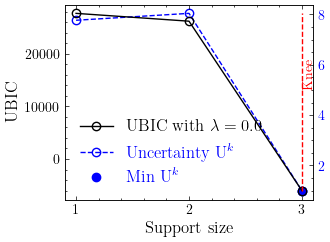

In [25]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}$", fontsize=12)
    ax.set_xlabel("Support size", fontsize=12)
    ax.vlines(best_bc+1, min(last_ubic), max(last_ubic), linestyles='--', color='red')
    ax.text(best_bc+1, np.mean(last_ubic), 'Knee', color='red', rotation=90, verticalalignment='center')
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {round(abs(last_lam), 2)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='lower left', fontsize=12)
    plt.tight_layout()
    # plt.savefig(f"Figures/ubic_ks_noise{int(noise_lv)}.pdf")
    plt.show()

### Selective inference

In [26]:
from selective_inference import sfs_si, stepwise_selective_inference, subset_fdr
import fpsample
from dppy.finite_dpps import FiniteDPP

In [27]:
n_samples = 120
test_subset = [8, 10, 13, 26]
si_result = None
for _ in range(10):
    np.random.seed(random.randint(0, 100))
    sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(120)]))
    si_result = sfs_si(1, 
                       StandardScaler().fit_transform(X_pre[:, test_subset])[sample_indices], 
                       y_pre.ravel()[sample_indices], 
                       4, sigma=np.std(y_pre))
    if si_result is not None:
        break
    
print("SFS")
si_result

invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide


SFS


invalid value encountered in scalar divide


SI_result(A=[2, 0, 1, 3], k=4, sigma=1.1451002261171417, p_values=[6.337963120283997e-21, 8.1157933621443e-17, 1.7725727811142682e-14, 0.834448393257772], CIs=[[-3.2347660053037277,-1.5685988522363077], [-4.618269979427628,-2.682977692950998], [-3.8030087463312805,-2.198929365794393], [-0.17676433636343972,0.21896247114055375]])

In [28]:
from si4pipeline import ( 
                        construct_pipelines, 
                        extract_features, 
                        initialize_dataset, 
                        intersection, 
                        lasso, 
                        marginal_screening, 
                        stepwise_feature_selection, 
                        union, 
                        PipelineManager
                        )

In [29]:
n_samples = 250*(best_bc+1)
# max_fdr = 0.2; false_discovery_control_method = 'by'
max_fdr = 0.2; false_discovery_control_method = 'bh'
# max_fdr = 0.2; false_discovery_control_method =  None
for bs in best_subsets:
    fdrs = []
    for _ in range(len(y_pre)//n_samples):
        X_test = X_pre_top[:, bs]
        y_test = y_pre.ravel()
        
        np.random.seed(random.randint(0, 100))
        # sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
        sample_indices = fpsample.bucket_fps_kdline_sampling(X_test, n_samples=n_samples, h=3) # Farthest Point Sampling (FPS) is better!!!
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        # FPS + k-DPP
        DPP = FiniteDPP('likelihood', **{'L': X_test.dot(X_test.T)})
        DPP.flush_samples()
        for _ in range(n_samples//(len(bs))):
            DPP.sample_exact_k_dpp(size=len(bs))
        sample_indices = np.unique(np.ravel(DPP.list_of_samples))
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        
        manager = stepwise_selective_inference(support_size=X_test.shape[1])
        M, p_list = manager.inference(X_test, y_test, np.std(y_test))
        if false_discovery_control_method is not None:
            p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
        # print(M, p_list, np.array(p_list) < 0.05)
        fdrs.append(subset_fdr(p_list))
        
    fdrs = np.array(fdrs)
    print(fdrs.mean(), stats.wilcoxon(fdrs-max_fdr, alternative='less').pvalue)

# extra = X_pre[:, np.argmin([np.linalg.lstsq(np.hstack((X_pre_top, (_-_.mean()/_.std()).reshape(-1, 1))), y_pre, rcond=None)[1][0] for _ in X_pre.T])]
# extra = (extra-extra.mean())/extra.std()
# extra = extra.reshape(-1, 1)
# fdrs = []
# for _ in range(len(y_pre)//n_samples):
#     X_test = np.hstack((X_pre_top, extra))
#     y_test = y_pre.ravel()
    
#     np.random.seed(random.randint(0, 100))
#     # sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
#     sample_indices = fpsample.bucket_fps_kdline_sampling(X_test, n_samples=n_samples, h=3) # Farthest Point Sampling (FPS) is better!!!
#     X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
#     # FPS + k-DPP
#     DPP = FiniteDPP('likelihood', **{'L': X_test.dot(X_test.T)})
#     DPP.flush_samples()
#     for _ in range(n_samples//(len(best_subsets)+1)):
#         DPP.sample_exact_k_dpp(size=len(best_subsets)+1)
#     sample_indices = np.unique(np.ravel(DPP.list_of_samples))
#     X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
    
#     manager = stepwise_selective_inference(support_size=X_test.shape[1])
#     M, p_list = manager.inference(X_test, y_test, np.std(y_test))
#     # print(M, p_list, subset_fdr(p_list) < 0.01, np.array(p_list) < 0.05)
#     fdrs.append(subset_fdr(p_list))
    
# fdrs = np.array(fdrs)
# print(Counter(fdrs < max_fdr), fdrs.mean())

0.0 0.0001220703125
1.2374716636015115e-14 0.0001220703125
0.0 0.0001220703125


In [30]:
# max_fdr = 0.2; false_discovery_control_method = 'by'
max_fdr = 0.2; false_discovery_control_method = 'bh'
# max_fdr = 0.2; false_discovery_control_method =  None
for bs in best_subsets:
    X_test = X_pre_top[:, bs]
    y_test = y_pre.ravel()
    
    manager = stepwise_selective_inference(support_size=X_test.shape[1])
    M, p_list = manager.inference(X_test, y_test, np.std(y_test))
    if false_discovery_control_method is not None:
        p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
    fdr = subset_fdr(p_list)
    
    print(fdr)

0.0
0.0
0.0


### Visualization ###

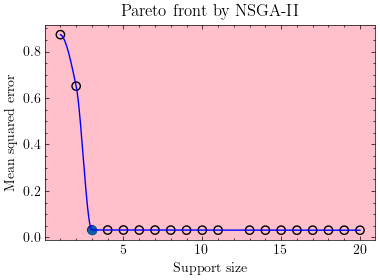

In [ ]:
from scipy.interpolate import CubicSpline, PchipInterpolator
if load_pareto_front:
    pareto_front = np.load(f"./Cache/pf_ks_noise{int(noise_lv)}.npy", allow_pickle=True)
    pareto_front = problem.evaluate(pareto_front)
else:
    pareto_front = res.F
pareto_front = pareto_front[np.argsort(pareto_front[:, 1])]
spline = PchipInterpolator(pareto_front[:, 1], pareto_front[:, 0])
x_plot = np.linspace(pareto_front[:, 1].min(), pareto_front[:, 1].max(), len(pareto_front[:, 1])*100)

bg_color = 'pink'
with plt.style.context(['science']):
    plt.rcParams['axes.facecolor'] = bg_color
    plt.figure(figsize=(4, 3))
    plt.plot(x_plot, spline(x_plot), color='blue')
    plt.scatter(pareto_front[:, 1], pareto_front[:, 0], facecolor='None', edgecolors='black')
    plt.scatter([_ for _ in est_complexities], pareto_front[:, 0][[_-1 for _ in est_complexities]])
    plt.ylabel("Mean squared error")
    plt.xlabel("Support size")
    plt.title("Pareto front by NSGA-II")
    plt.tight_layout()
    plt.savefig(f"Figures/pf_ks_noise{int(noise_lv)}.pdf")
    plt.show()

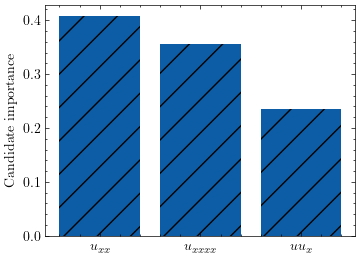

In [29]:
import sympy
def show_polynomial_derivative(p: int, d: int):
    if p < 0 or d < 0:
        raise ValueError("Polynomial degree and derivative order must be non-negative integers.")
    polynomial_part = sympy.Symbol('u') if p == 1 else sympy.Symbol(f"u^{p}") if p > 0 else sympy.Integer(1)    
    derivative_part = f"u_{'x'*d}" if d > 0 else ''
    if len(derivative_part) < 1:
        return sympy.simplify(polynomial_part)
    derivative_part = sympy.Symbol(derivative_part)
    return sympy.simplify(polynomial_part*derivative_part)
effective_candidates_name = ['$'+sympy.latex(show_polynomial_derivative(_[0][0], _[0][1]))+'$' for _ in effective_candidates]
with plt.style.context(['science']):
    fig, ax = plt.subplots(figsize=(4, 3))
    bars = ax.bar(effective_candidates_name, [_[1] for _ in effective_candidates])
    for i, bar in enumerate(bars):
        if i < len(top_candidates):
            bar.set_hatch('/')
    ax.set_ylabel("Candidate importance")
    plt.savefig(f"Figures/importance_ks_noise{int(noise_lv)}.pdf")
    plt.show()

In [32]:
v = 1e-2
while 1:
    bme = [log_evidence(X_pre_top, y_pre, effective_indices=bs, v=v) for bs in best_subsets]
    if np.argmax(bme) >= knee_finder(b_bics): break
    else: v *= 10
bme_knee = knee(range(len(bme)), bme, 0.95, 'linear', direction='increasing')
bme, np.argmax(bme), bme_knee

([-13814.443503301149, -13077.811491903905, 965.155280551726], 2, 2)

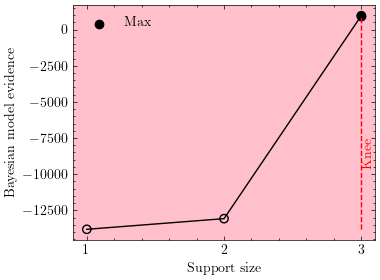

In [33]:
with plt.style.context(['science']):
    plt.rcParams['axes.facecolor'] = 'pink'
    plt.figure(figsize=(4, 3))
    plt.plot(range(1, len(bme)+1), bme, color='black')
    plt.scatter(range(1, len(bme)+1), bme, facecolor='None', edgecolors='black')
    plt.scatter(np.argmax(bme)+1, bme[np.argmax(bme)], label='Max', color='black')
    plt.vlines(bme_knee+1, min(bme), max(bme), linestyles='--', color='red')
    plt.xlabel("Support size")
    plt.ylabel("Bayesian model evidence")
    plt.xticks(range(1, len(bme)+1))
    plt.text(bme_knee+1, np.mean(bme), 'Knee', color='red', rotation=90, verticalalignment='center')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Figures/bme_ks_noise{int(noise_lv)}.pdf")
    plt.show()